In [1]:
import math
import cvxpy
import numpy as np
import cubic_spline_planner
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import importlib
import MPC
importlib.reload(MPC)
from MPC import MPC, Vehicle, Simulation, plot_car
from tqdm.autonotebook import tqdm

/mnt/c/Users/anders/OneDriveDTU/Dokumenter/Courses/Bayesian/bayesian-state-space-models/MPC.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [20]:
class Trajectory:
    def __init__(self):

        x1 = np.linspace(5, 43, 6)
        x2 = np.repeat(42.5, 3) + np.random.normal(0, 0.75, 3)
        x2 = np.clip(x2, 41, 44)

        y1 = np.repeat(3, 6) + np.random.normal(0, 0.75, 6)
        y1 = np.clip(y1, 2, 4)

        y2 = np.linspace(7.5, 17.5, 3)

        self.x_points = np.r_[1, x1, x2, 42.5]
        self.y_points = np.r_[3, y1, y2, 20]

        self._states = None
        self._measurements = None

        self.cx = None
        self.cy = None
        self.states_hist = None
        self.controls_hist = None

    @property
    def states(self):
        if self._states is None:
            self._calculate_states()
        return self._states

    @property
    def measurements(self):
        if self._measurements is None:
            self._calculate_measurements()
        return self._measurements
    
    # Based on gut feelings
    def speed_reduction(self, cyaw, sp):
        speed_reduction = np.diff(cyaw)
        speed_reduction = np.concatenate([speed_reduction[int(len(speed_reduction)*0.025):],
                                        np.linspace(speed_reduction[-1], 0, int(len(speed_reduction)*0.025))])
        speed_reduction = np.convolve(speed_reduction, np.ones(30)/30, mode='same')
        speed_reduction = ((1.5*np.max(np.abs(speed_reduction)) - np.abs(speed_reduction)) / (1.5*np.max(np.abs(speed_reduction))))
        speed_reduction = np.clip(speed_reduction, 0, 1)
        speed_reduction *= np.concatenate([np.ones(int(len(speed_reduction)*0.95)+1), np.linspace(1, 0, int(len(speed_reduction)*0.05))])
        
        sp_new = sp
        sp_new[:-1] *= speed_reduction
        
        return sp_new

    def _calculate_states(self):
        self.cx, self.cy, cyaw, ck, s = cubic_spline_planner.calc_spline_course(self.x_points, self.y_points, ds=0.1)
        initial_state = Vehicle(x=self.cx[0], y=self.cy[0], yaw=cyaw[0], v=0.0)
        dl = 1.0
                
        simulation = Simulation(initial_state, goal_speed=0.5, target_speed=3)
        
        # Speed profile
        sp = np.array(simulation.calc_speed_profile(self.cx, self.cy, cyaw))
        sp = self.speed_reduction(cyaw, sp)
        
        # Simulation
        self.states_hist, self.controls_hist = simulation.simulate(self.cx, self.cy, cyaw, ck, dl, sp=sp)

        # Get simulation states
        x, y, v, yaw = self.states_hist['x'], self.states_hist['y'], self.states_hist['v'], self.states_hist['yaw']        

        # Calculate dx and dy
        dx = np.empty_like(x)
        dy = np.empty_like(y)
        for i in range(len(x)):
            dx[i] = v[i] * math.cos(yaw[i]) * initial_state.dt
            dy[i] = v[i] * math.sin(yaw[i]) * initial_state.dt
            
        # Downsample to 2Hz
        skip = int((1 / initial_state.dt) / 5)
        x, y, dx, dy = x[::skip], y[::skip], dx[::skip], dy[::skip]            

        self._states = np.c_[x, y, dx, dy]

    def _calculate_measurements(self, std=1):
        x, y, dx, dy = self.states[:, 0], self.states[:, 1], self.states[:, 2], self.states[:, 3]
        
        x = x + np.random.normal(0, std, len(x))
        y = y + np.random.normal(0, std, len(y))
        dx = dx + np.random.normal(0, std, len(dx))
        dy = dy + np.random.normal(0, std, len(dy))
        self._measurements = np.c_[x, y, dx, dy]

    def get_data(self):
        return self.states, self.measurements
    
    def plot(self, states, measurements):

        fig, ax = plt.subplots(1, 1, figsize=(16, 6))

        ax.plot(measurements[:, 0], measurements[:, 1], 'o', label='Measurements', markersize=3)
        ax.plot(self.x_points, self.y_points, 'x', label='Waypoints', markersize=10)
        ax.plot(states[:, 0], states[:, 1], label='Trajectory', linewidth=2)
        

        ax.hlines(1, 1, 45, color='k', linestyle='solid', linewidth=1)
        ax.hlines(5, 1, 40, color='k', linestyle='solid', linewidth=1)
        ax.vlines(45, 1, 20, color='k', linestyle='solid', linewidth=1)
        ax.vlines(40, 5, 20, color='k', linestyle='solid', linewidth=1)

        ax.set_xlim(0, 46)
        ax.set_ylim(0, 21)
        ax.set_aspect('equal')

        ax.legend()

        plt.show()

    def animate(self, states, measurements, filename='animation'):
        fig, ax = plt.subplots(1, 1, figsize=(16, 6))
        
        target_inds = self.controls_hist['target_inds']        

        def aux_animate(i):
            ax.cla()
            ax.plot(self.x_points, self.y_points, "kx", markersize=10)
            ax.plot(states[:i, 0], states[:i, 1], "-r", label="trajectory")
            ax.plot(measurements[:i, 0], measurements[:i, 1], 'bx', markersize=3, label="measurements")
            ax.plot(self.cx[target_inds[i]], self.cy[target_inds[i]], "xg", label="target")
            plot_car(ax, states[i, 0], states[i, 1], self.yaw[i], steer=self.d[i])#, cabcolor="k", truckcolor="k")
            ax.axis("equal")
            ax.grid(True)
            ax.set_title("Time [s]:" + str(round(self.t[i], 2)) + ", speed [km/h]:" + str(round(self.v[i] * 3.6, 2)))
            ax.hlines(1, 1, 45, color='k', linestyle='solid', linewidth=1)
            ax.hlines(5, 1, 40, color='k', linestyle='solid', linewidth=1)
            ax.vlines(45, 1, 20, color='k', linestyle='solid', linewidth=1)
            ax.vlines(40, 5, 20, color='k', linestyle='solid', linewidth=1)

            ax.set_xlim(0, 46)
            ax.set_ylim(0, 21)
            ax.set_aspect('equal')

        ani = animation.FuncAnimation(fig, aux_animate, frames=len(self.t), repeat=False)

        # Save animation with progress bar
        with tqdm(total=len(self.t)) as pbar:
            ani.save(f'{filename}.gif', writer='Pillow', fps=25, progress_callback=lambda i, n: pbar.update())
            
        plt.close()


In [22]:
trajectory = Trajectory()
states, measurements = trajectory.get_data()

MPC: 0it [00:00, ?it/s]

Goal


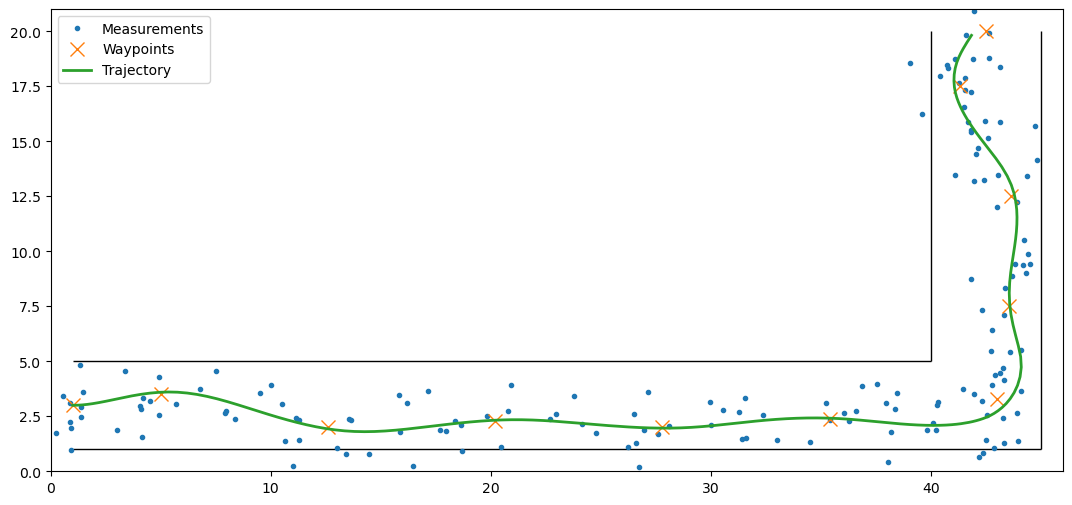

In [23]:
trajectory.plot(states, measurements)

In [89]:
trajectory.animate(states, measurements, filename='animation')

  0%|          | 0/398 [00:00<?, ?it/s]

MovieWriter Pillow unavailable; using Pillow instead.
